##1-İMPORTİNG LİBRARİES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
keras = tf.keras

In [ ]:
def plot_series(time,series,format = "-",start = 0,end = None,label = None):
  plt.plot(time[start:end],series[start:end],format,label = label)
  plt.xlabel("Time")
  plt.ylabel("Series")
  if label:
    plt.legend(fontsize = 14)
  plt.grid(True)

def trend(time,slope = 0):
  return time* slope

def seasonal_pattern(season_time):
  return np.where(season_time<0.4,
                  np.cos(season_time*2*np.pi),
                  1/np.exp(3*season_time))
  
def seasonality(time,period,amplitude=1,phase = 0):
  season_time =((time + phase) % period)/period
  return amplitude * seasonal_pattern(season_time)

def white_noise(time,noise_level = 1,seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

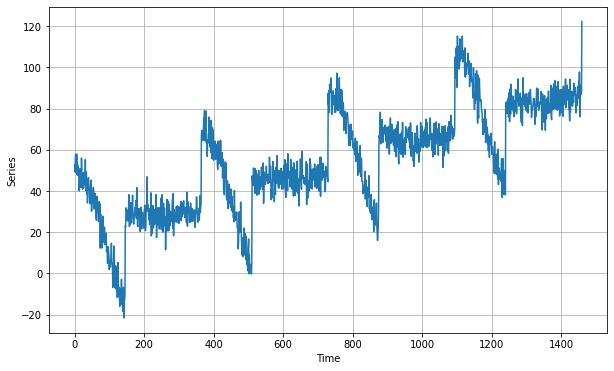

In [ ]:
time = np.arange(4*365 + 1)

slope = 0.05
baseline = 10
amplitude =40
series = baseline  + trend(time,slope)+ seasonality(time,period = 365,amplitude = amplitude)

noise_level = 5
noise = white_noise(time,noise_level,seed = 42)

series += noise

plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

##Makine Öğrenimi ile Tahmin
İlk olarak, önceki 30 adımda verilen bir sonraki adımı tahmin etmek için bir model eğiteceğiz, bu nedenle eğitim için 30 adımlık pencerelerden oluşan bir veri seti oluşturmamız gerekiyor.

In [ ]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Linear Model

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 13ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - l

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 67.6867 - mae: 68.1863 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 52.3572 - mae: 52.8561 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 34.6465 - mae: 35.1446 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 17.6521 - mae: 18.1484 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 8.4604 - mae: 8.9488 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9765 - mae: 8.4627 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 7.9201 - mae: 8.4035 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 7.8785 - mae: 8.3609 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 7.8191 - mae: 8.3014 - lr: 1.84

(1e-06, 0.001, 0.0, 20.0)

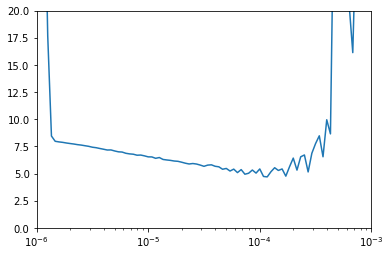

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

model belirli bir noktaya kadar iyi gitti fakat bir noktadan sonra çok öğrendi ve patladı bunun düzeltmemiz gerekiyor

In [ ]:
keras.backend.clear_session() # başka oturumlar varsa temizle
tf.random.set_seed(42) # random verisini sürekli aynı çıkması için sabitle
np.random.seed(42) # aynı şekilde sabitle

window_size = 30  # yarın olacakların kendinden 30 gün öncesi ile aynı olacağı penceresi
# datalarımızı ayarlıyoruz
train_set = window_dataset(x_train,window_size)
valid_set = window_dataset(x_valid,window_size)

# modelimizi yaratıyoruz
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape= [window_size])  # 1 nöronlu giriş boyutu windows_size kadar olan model oluşturduk
])

# modelimizin parametrelerini giriyoruz
# ilk olarak optimizer oluşturuyoruz
optimizer = keras.optimizers.SGD(lr = 1e-5,momentum = 0.9)  # 1e-5 ve momentumu açıkla

model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience = 10) # Patlama olmadan önce durdurmak istiyoruz

# modeli eğitelim 
model.fit(train_set,epochs = 500,
          validation_data = valid_set,
          callbacks = [early_stopping])





# EXERCİSES

## importing libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
keras = tf.keras

In [ ]:
# Grafikleri göstereceğimiz bir fonksiyon yazalım
def plot_series(time,series,format = "-",start = 0,end = None,label = None):
  plt.plot(time[start:end],series[start:end],format,label = label)
  plt.xlabel("Time")
  plt.ylabel("Series")
  if label:
    plt.legend(fontsize = 14)
  plt.grid(True)

##2- Trend oluşturalım
  * Trend : Belirli bir şekilde artış-azalış(yukarı çıkan ok aşağı inen ok ) gibi göstergemizdir

In [ ]:
# trend fonksiyonu oluşturuyoruz
def trend(time,slope = 0):  # slope eğimi belirtir
  return slope* time
# doprusal bir trend döndürür

## 3- Zaman adımlarını time,series oluşturalım

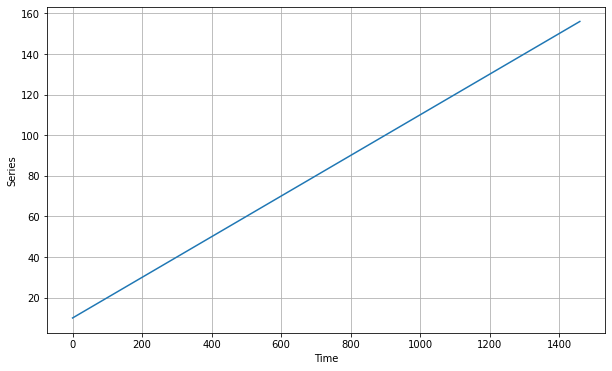

In [ ]:
time = np.arange(4*365+1) # 4 senelik bir sayı dizisi oluşturuyoruz
baseline = 10  # taban çizgimiz - başlangıç değerimiz

series = baseline  + trend(time , slope = 0.1) # zaman serisini 10+1*0.1 , 10+2*0.1,10+3*0.1 ... = 10.1,10.2,10.3... şeklinde oluşturuyoruz

# grafikte time - series gösterelim 

plt.figure(figsize = (10,6))
plot_series(time,series)
plt.show()

In [ ]:
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [ ]:
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

## 4 - mevsimsellik oluşturalım
  * Mevsimsellik özetle : dondurma satışı yazın fazladır kışın azdır yazın tepe oluşturur,kışın çukur 4 senelik bir grafikte bunu göstermeye çalışırsak tepe-çukur-tepe,çukur ... gibi bir yapı oluşturuz

In [ ]:
# Mevsimsel iniş çıkış kalıplarını gösteren bir fonksiyon yazalım

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2*np.pi),
                  1/np.exp(3*season_time))
  
def seasonality(time,period,amplitude =1,phase = 0):  # amplitude = genlik : yukarı aşağı ne kadar gideceğini , period : tekrarlama , phase =faz = ne kadar sağ sol yer değiştireceği gösterir
  season_time = ((time + phase) % period)/ period
  return amplitude * seasonal_pattern(season_time)

# bu tamamen uydurulma bir mevsimsel kalıp fonksiyonudur
# seasonal pattern fonskiyonunda 0.4 ü cos fonksiyonu 0.6 sı np.exp euler sabiti tabanı ile içine yazılanı üs kabul ederek hesaplama yapar yani 1/2.71...üssü 3*season_time


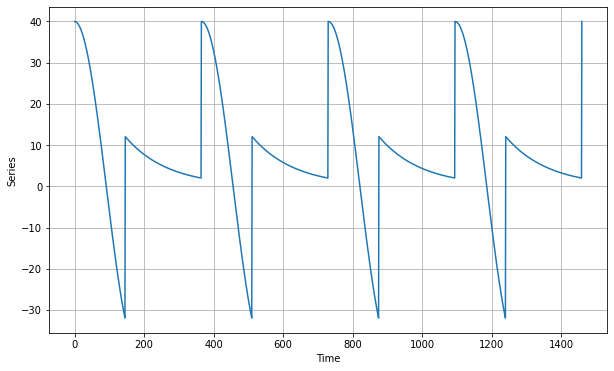

In [ ]:
amplitude = 40
series = seasonality(time , period = 365,amplitude = amplitude)

plt.figure(figsize = (10,6))
plot_series(time,series)
plt.show()

Görüldüğü üzere tamamen uydurma 
- 365 günde bir kendini tekrar eden
- 40 aşağı ve yukarı(amplitude) genlikli
- 4*365 yani 4 sene uzunluğunda
- phase = faz =0 belirledik yani en başından başlayan(40 genlik'ten)
- mevsimsel yani çukur ve tepe (0 ile 160 time aralığı cos - 160 - 365 aralığı euler sabiti kısmı)

oluşturuldu

## 5- hem trend hem mevsimsellik olan bir series oluşturalım

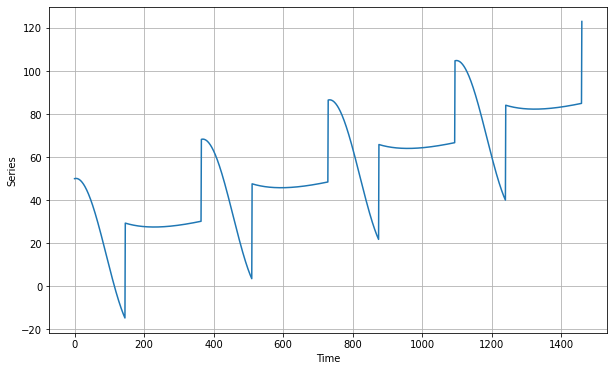

In [ ]:
slope = 0.05 # eğim 

series = baseline + trend(time , slope) + seasonality(time , period = 365,amplitude = amplitude)

plt.figure(figsize = (10,6) )
plot_series(time,series)
plt.show()

 - Görüldğü üzere hem 
 - trend 0.05 eğimle doğrusal artan
 - hemde 365 period , 40 genlik , 0 faz ile mevsimsel iniş çıkışlı
 başlangıç değeri 10 + ... trend ve mevsimsellik olan bir series oluşturduk

## 6- GÜRÜLTÜ OLUŞTURUYORUZ 

In [ ]:
def white_noise(time,noise_level = 1,seed=None):  # white noise : temelde her frekansın aynı genliğe sahip olması durumunu anlatır.
  rnd = np.random.RandomState(seed)  # biz burada random sayılarla genlik oluşturacağız
  return rnd.randn(len(time)) * noise_level    # her zaman adımı için rastgele sayı üret ve genliği bulmak için gürültü seviyesiyle çarp

 ## Not : Normalde gürültü kendinden önceki ile ilişkilidir Biz buradan random sayılar ile belirledik

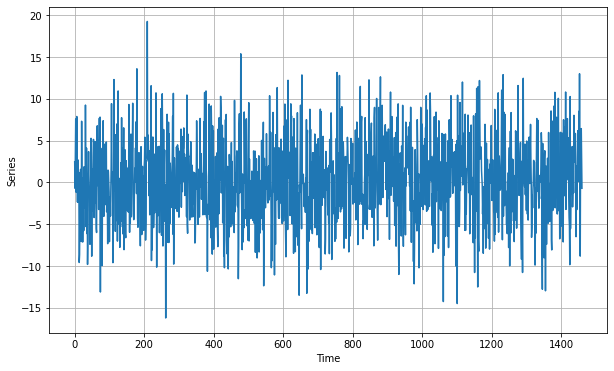

In [ ]:
noise_level = 5 # gürültü seviyesi

noise = white_noise(time,noise_level,seed =42)

plt.figure(figsize= (10,6))
plot_series(time,noise)
plt.show()


- Görüldüğü üzere genliklerinin hepsi birbirinden farklı 5 noise_level ayarlayarak gürültü oluşturduk
- bu gibi grafiklerde(gauss dağılımı) en doğru tahmin ortalamasını bulmak bu durumda 0 dersek en doğru tahmini yapmış oluruz

## 7 - series ' e gürültüyü ekleyelim 



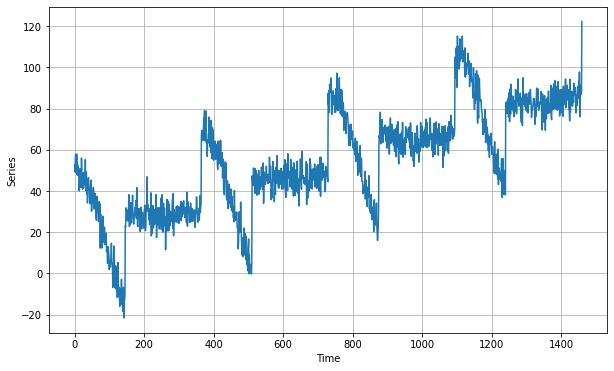

In [ ]:
series += noise 

plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

** ELİMİZDE 
- 10 BASELİNE(BAŞLANGIÇ) OLAN
- 0.05 TREND İLE DOĞRUSAL ARTAN
- 40 GENLİK 365 PERİOD 0.4 COS,0.6 EULER TABAN ORANIYLA MEVSİMSEL İNİŞ ÇIKIŞ GÖSTEREN
- GÜRÜLTÜYE SAHİP
BİR ZAMAN SERİSİNE SAHİBİZ

## 8-TEST_TRAİN DATA PROCESSİNG

1.   Normalde train test validasyon yani doğrulama hazırlamamız gerekiyor
2.   Veri sınırlı olduğu için validasyon verisi üzerinden test edecez
3.   1000.günden öncesi eğitim yani train datası 
4.  1000.günden sonrası validasyon yani doğrulama yapacağımız kısım



In [ ]:
split_time = 1000 # 1000.günden sonrasını validasyon için kullanacaz

time_train = time[:split_time] # 0-1000 gün zaman aralığı 
x_train = series[:split_time]  # 0-1000 gün aralığındaki zaman serisi verileri

time_valid = time[split_time:] # 1000-1460 günler aralığı zamanı
x_valid = series[split_time :] # 1000-1460 günleri arasında olan zaman seri verileri

## 9- NAİVE FORECASTİNG (SAF TAHMİN)
- Buradaki mantık bir önceki gün nasılsa yarında aynı şekilde devam ediyor kabul ediyoruz

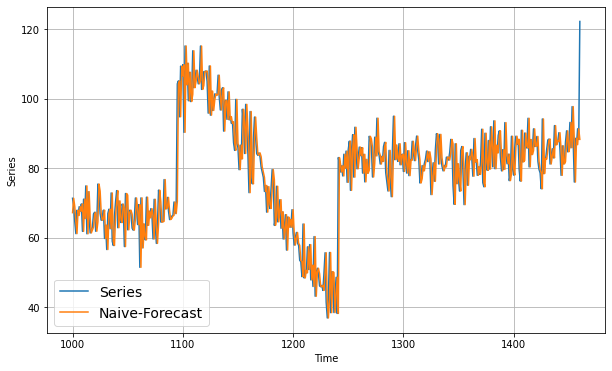

In [ ]:
# sadece doğrulama verileri için bir saf tahmin verisi oluşturacaz
# bizim saf tahminci 1000.günden değil verileri bir önceki günden başlayarak değer alacak 999.günden son güne kadar 

naive_forecast = series[split_time-1:-1]

plt.figure(figsize= (10,6))
plot_series(time_valid,x_valid,label = "Series")
plot_series(time_valid,naive_forecast,label="Naive-Forecast")
plt.show()

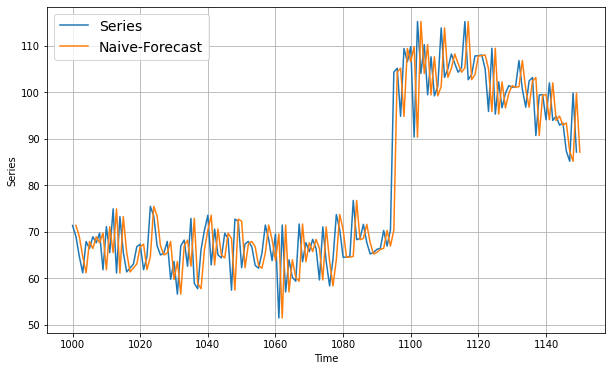

In [ ]:
# Tam göremediğimiz için yakınlaştırıyoruz

plt.figure(figsize = (10,6))
plot_series(time_valid,x_valid,start = 0,end=150,label = "Series")
plot_series(time_valid,naive_forecast,start =1,end=151,label = "Naive-Forecast")
plt.show()

**GÖRÜLDÜĞÜ ÜZERE BİZİM SAF TAHMİNCİMİZ BİR ÖNCEKİ GÜN NE OLDUYSA TEKRAR ETMEKTEDİR BAKALIM DOĞRULAMA DEĞERİ NEDİR**

In [ ]:
#DOĞRULAMA İÇİN TAHMİN DEĞERİNDEN GERÇEK DEĞERİ ÇIKARIP FARKINI BULUYORUZ
# NEGATİF SAYILAR TOPLANIRKEN GÖTÜRECEĞİ İÇİN FAKLARIN MUTLAK DEĞERİNİ ALIYORUZ(BAZEN KARELERİDE OLABİLİYOR)
# TOPLA VE ORTALAMASINI BUL
# ORTALAMA NE KADAR BÜYÜKSE HATA FAZLADIR ANLAMINA GELİYOR

errors = naive_forecast - x_valid  # Fark
abs_errors = np.abs(errors)  # mutlak
mae = abs_errors.mean()  # Topla ve adete böl yani ortalama al
mae

# MEAN ABSOLUTE ERROR ----> ORTALAMA MUTLAK HATA

5.9379085153216735

In [ ]:
## YADA BİR DİĞER ŞEKİLDE 
keras.metrics.mean_absolute_error(x_valid,naive_forecast).numpy()

5.9379085153216735

##MOVİNG AVERAGE

- Burdaki durum şu naive forecastte yarın bir önceki günün aynısı diyorduk
- Moving Average yani hareketli ortalamada diyoruz ki yarın önceki 30 günün ortalamasıdır diyecez
- Bu yüzden de ileri doğru her defasında bir önceki 30 günün ortalamasını alacağımız için hareketli ortalamaya ihtiyacımız var
- Hareketli ortalama almamız içinde ortalamayı bulmak için zaman penceresine window_size ihityacımız var

In [ ]:
# Şimdi fonksiyonumuzu yazalım 

def moving_average_forecast(series,window_size):
  forecast = []

  for time in range(len(series)-window_size):
    forecast.append(series[time:time+window_size].mean())
  return np.array(forecast)

# Şimdi burada diyoruz ki : 
# - forecast diye bir boş liste oluşturduk---> Bunun içine ortalama girecek window_size günü kadar
# - window_size = 1 olursa naive forecast olur
# window_size ile oynayarak bir sonraki günün kaç gün öncesinin ortalamasıyla aynı olacağını belirliyoruz

In [ ]:
# daha hızlı hesaplanması için alternatif fonksiyon

def moving_average_forecast(series,window_size):

  mov = np.cumsum(series)
  mov[window_size : ] = mov[window_size :] - mov[: - window_size]
  return mov[window_size - 1 : -1] / window_size 

##11-HAREKETLİ ORTALAMAMIZI OLUŞTURALIM

In [ ]:
moving_avg = moving_average_forecast(series,30)[split_time-30:]

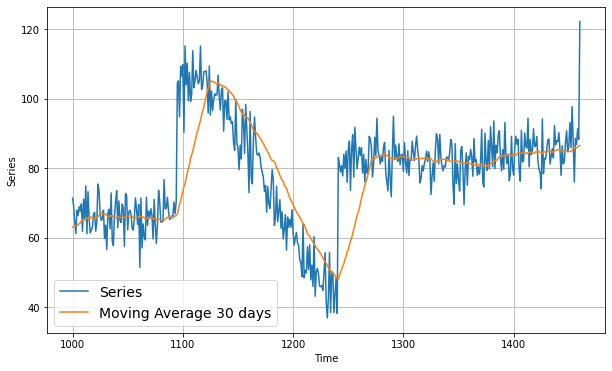

In [ ]:
plt.figure(figsize = (10,6))
plot_series(time_valid,x_valid,label = "Series")
plot_series(time_valid,moving_avg,label="Moving Average 30 days")

**ŞİMDİ BU SONUÇLARA BAKTIĞIMIZDA(TURUNCU) NAİVE FORECASTE GÖRE GECİKME ÇOK FAZLA ARTACAKMI AZALACAK MI BİR SİNYAL GÖRMÜYORUZ HALİYLE MUTLAK HATA ORTALAMASI DAHA YÜKSEK ÇIKACAK**

In [ ]:
keras.metrics.mean_absolute_error(x_valid,moving_avg).numpy()
# Görüldüğü üzere daha yüksek çıktı 
# - ama temiz bir tahmin gürültü mevsimsellik olmadan 

7.142418570620786


- ŞİMDİ BUNU DÜZELTME İŞLEMİ YAPALIM
  - BURADA TAHMİNİ KÖTÜ YAPMASININ SEBEBİ TREND VE MEVSİMSELLİKTEKİ DEĞİŞİM
  - TREND VE MEVSİMSELLİĞİ KALDIRIRSAK TAHMİN ETME ORANI YÜKSELECEKTİR(YANİ BİR SENELİK VERİ DE ÇALIŞALIM)

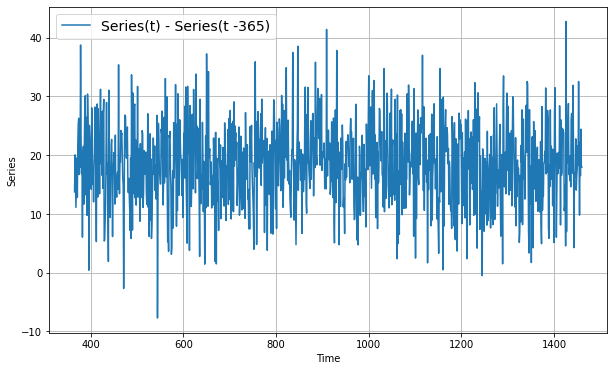

In [ ]:
diff_series= (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize = (10,6))
plot_series(diff_time,diff_series,label= "Series(t) - Series(t -365)")

**GÖRÜLDÜĞÜ ÜZERE SAF TRENDSİZ VE MEVSİMSELSİZ BİR SERİ ELDE ETTİK**

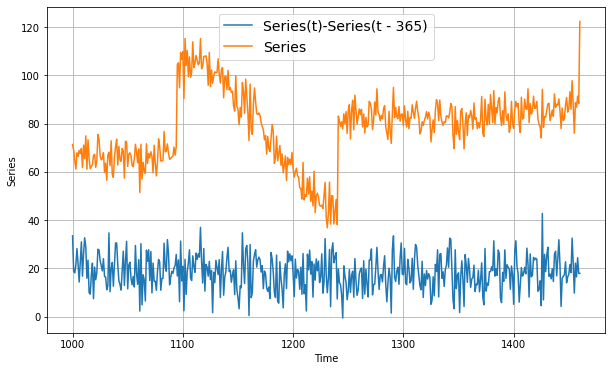

In [ ]:
# ŞİMDİ NORMAL SERİMİZ İLE TEMİZLEDİĞİMİZ SERİYE BAKALIM

plt.figure(figsize = (10,6))
plot_series(time_valid,diff_series[split_time-365 : ],label="Series(t)-Series(t - 365)")
plot_series(time_valid,x_valid,label ="Series")
plt.show()

**şimdi dikkat edildiği üzere biz daha stabil ortalama ile ilerleyen bir seri oluşturduk.Baktığında sadece noise gibi...**

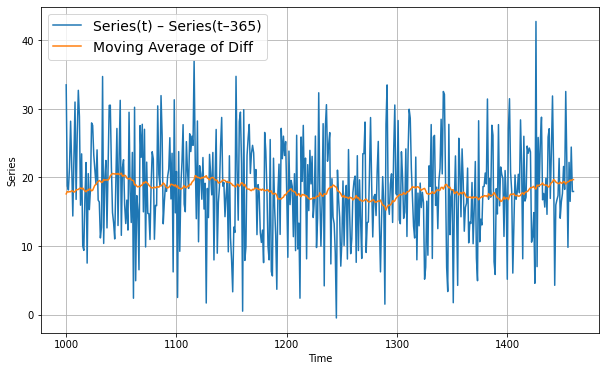

In [ ]:
## Gelelim şimdi bizim hareketli ortalama tahminimizi birlikte gösterelim
# Görülecekki bir öncekinden çok daha uygun tahmin edecek(ORtalamasını)

# diff_moving_avg = moving_average_forecast(diff_series,50)[split_time-365-50:] # Şimdi burada kendinden önceki 50 gün ortalaması yapıyoruz(window_size) /// 365 çıkarmamızın sebebi seriyi düzeltmek için 365 gün çıkardığımız için

diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

**ORTALAMA OLARAK ÇOK STABİL BİR TAHMİN**

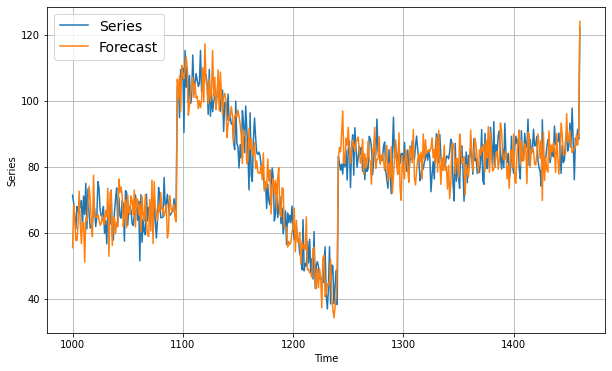

In [ ]:
## ŞİMDİ ÇIKARDIKLARIMIZI EKLEYEREK TAHMİNE BAKALIM

diff_moving_avg_plus_past = series[split_time - 365 : -365] + diff_moving_avg

plt.figure(figsize = (10,6))
plot_series(time_valid,x_valid,label = "Series")
plot_series(time_valid,diff_moving_avg_plus_past,label="Forecast")
plt.show()








In [ ]:
# Şimdi ortalama mutlak hatasına bakalım 
keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_past).numpy()

5.8393105629958955

Saf tahminden daha iyi, güzel. Ancak tahminler biraz fazla rastgele görünüyor, çünkü biz sadece gürültülü olan geçmiş değerleri ekliyoruz. Gürültünün bir kısmını ortadan kaldırmak için geçmiş değerler üzerinde hareketli bir ortalama kullanalım:

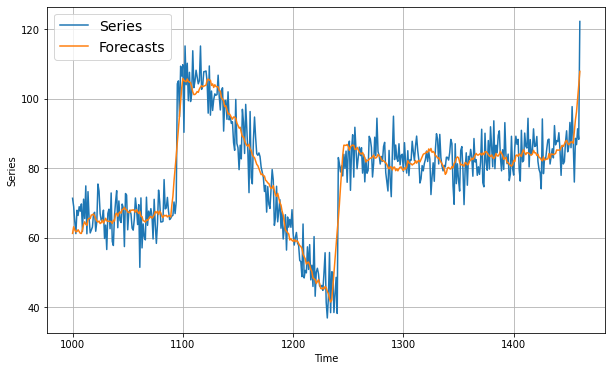

In [ ]:
# Geçmiş 1 sene önceki değerlerden 15 gün öncesi için bir ortalama hesaplayıp o şekilde tahmin edelim 

diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [ ]:
keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_smooth_past).numpy()

4.566859958970771

**ÇOK DAHA BAŞARILI**